# 모델링

## train_test_split

In [113]:
import pandas as pd
df_fin = pd.read_csv('전처리_final.csv')

In [114]:
#df_fin = pd.read_csv('전처리_screen_act있는.csv')

In [115]:
df_fin

,dist_rank,genre_rank,direct_rank,네이버_기대지수,star_buzz,movie_buzz_naver,google_trend,Target
0,4,5,67,1274.0,1629,22,773.0,0
1,8,13,67,3838.0,581,19,387.0,0
2,2,13,41,494.0,943,30,616.0,0
3,8,13,94,162.0,111,6,0.0,0
4,3,13,67,800.0,335,5,1674.0,0
...,...,...,...,...,...,...,...,...
570,3,13,5,13693.0,1987,219,947.0,1
571,2,13,72,10731.0,1196,124,886.0,0
572,4,1,5,4941.0,1413,379,0.0,1
573,7,8,100,247.0,147,25,459.0,0


In [116]:
y = df_fin['Target']
x = df_fin.drop('Target', axis=1)

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

정규화 안하는게 더 좋은 결과를 낳음

## 보팅(pycaret, logistic regression, linear discriminant, ridge classifier)
accuracy - 정확도,
f1 score - 모델 성능, 얼마나 잘 맞추는가
이 모델들 외에도, knn, xgboost, ada boost,cat boost, random forest 등 많이 해봤지만 다 정확도와 f1 score가 낮게 나와서 뺌

### logistic regression

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [119]:
lr = LogisticRegression(penalty = 'l2', random_state=100)
lr.fit(X_train, y_train)
lr_pred1 = lr.predict(X_test)
print('acc',accuracy_score(lr_pred1, y_test)) 
print('f1',f1_score(y_test, lr_pred1))

acc 0.791907514450867
f1 0.4375


### linear discriminant

In [120]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [121]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
#lda.transform(X_train)
lda_pred1 = lda.predict(X_test)
print('acc', accuracy_score(lda_pred1, y_test))
print('f1',f1_score(y_test, lda_pred1))

acc 0.791907514450867
f1 0.4545454545454545


### rigde classifier

In [122]:
from sklearn.linear_model import RidgeClassifier

In [123]:
rc = RidgeClassifier(random_state = 100)
rc.fit(X_train, y_train)
rc_pred1 = rc.predict(X_test)
print("Accuracy:",accuracy_score(y_test, rc_pred1))
print("F1 score:",f1_score(rc_pred1, y_test))
# 좋은 결과가 나오지만 보팅에 넣을 수가 없음

Accuracy: 0.791907514450867
F1 score: 0.4375


### pycaret

In [124]:
from pycaret.classification import *
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_fin, test_size=0.3, random_state=100)
cat_features = ['genre_rank', 'direct_rank','dist_rank']  # 범주 변수들 설정해줌

In [125]:
setup_clf = setup(data = train, target= 'Target', fold_shuffle=True, categorical_features=cat_features)

,Description,Value
0,session_id,4980
1,Target,Target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(402, 8)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [126]:
top10 = compare_models(sort='F1', n_select=10, fold=5) 
# 모델들을 비교하여 가장 좋은 순으로 보여줌
# sort를 accuracy보다 F1으로 하는것이 더 좋은 f1score랑 accuracy를 낳음,fold 10번하는게 정확도가 올라감

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5086,0.5702,0.6846,0.2858,0.3981,0.1002,0.1252,0.0140
dt,Decision Tree Classifier,0.7048,0.5763,0.3341,0.3734,0.3441,0.1576,0.1616,0.0080
nb,Naive Bayes,0.7510,0.6634,0.2901,0.4417,0.3349,0.1986,0.2092,0.0080
xgboost,Extreme Gradient Boosting,0.7474,0.6930,0.3066,0.4173,0.3317,0.1955,0.2040,0.0880
lightgbm,Light Gradient Boosting Machine,0.7368,0.6577,0.2604,0.3918,0.3098,0.1603,0.1643,0.2080
gbc,Gradient Boosting Classifier,0.7688,0.6755,0.2286,0.4767,0.3020,0.1938,0.2105,0.0500
lda,Linear Discriminant Analysis,0.7404,0.6275,0.2440,0.4288,0.2931,0.1537,0.1693,0.0100
ada,Ada Boost Classifier,0.7367,0.6179,0.2440,0.4420,0.2900,0.1509,0.1711,0.0480
lr,Logistic Regression,0.7758,0.6560,0.2132,0.5533,0.2809,0.1927,0.2280,0.9340
catboost,CatBoost Classifier,0.7794,0.7154,0.2000,0.4667,0.2786,0.1966,0.2218,1.0620


In [127]:
tuned_top5 = [tune_model(i, fold=5) for i in top10[:5]]
# 상위 4개, 5개로 했을 때 제일 좋은 결과가 나옴

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7544,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7679,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7679,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7679,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7679,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.7652,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0054,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [128]:
blender_top5 = blend_models(estimator_list=tuned_top5) #보팅(voting)해줌

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7586,0.7208,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7500,0.3878,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7500,0.7619,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6786,0.5442,0.0000,0.0000,0.0000,-0.1250,-0.1601
4,0.7500,0.6054,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7500,0.7823,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7857,0.7727,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7857,0.5379,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7857,0.7348,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7857,0.8182,0.0000,0.0000,0.0000,0.0000,0.0000


In [129]:
final_model = finalize_model(blender_top5)
prediction = predict_model(final_model, data=test)

In [130]:
prediction['Target'] = prediction['Target'].astype(int)
prediction['Label'] = prediction['Label'].astype(float)
prediction['Label'] = prediction['Label'].astype(int)

In [131]:
from pycaret.utils import check_metric
check_metric(prediction['Target'], prediction['Label'], metric = 'Accuracy') # 정확도

0.7746

In [132]:
# F1score
check_metric(prediction['Target'], prediction['Label'], metric = 'F1') 

0.3607

## K-fold 및 보팅

In [133]:
# pycaret
from sklearn.model_selection import KFold
kf = KFold(n_splits =  10, shuffle = True, random_state = 100) # fold 10번하기

acc_list = []
py_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    final_model.fit(tr_x, tr_y)
    
    pred = final_model.predict(val_x)
    sub_pred = final_model.predict(X_test)
    acc = accuracy_score(val_y, pred)
    
    acc_list.append(acc)
    
    py_pred += (sub_pred / 10)

In [134]:
print('acc 평균:', np.mean(acc_list)) 
print('pycaret acc:',accuracy_score(np.round(py_pred), y_test)) 
print('pycaret f1 score', f1_score(np.round(py_pred), y_test)) 

acc 평균: 0.7836585365853659
pycaret acc: 0.7687861271676301
pycaret f1 score 0.42857142857142855


In [135]:
# LogisticRegression
from sklearn.model_selection import KFold
kf = KFold(n_splits =  10, shuffle = True, random_state = 100) # fold 10번하기

lr = LogisticRegression(penalty = 'l2', random_state = 100)
acc_list = []
lr_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    lr.fit(tr_x, tr_y)
    
    pred = lr.predict(val_x)
    sub_pred = lr.predict(X_test)
    acc = accuracy_score(val_y, pred)
    
    acc_list.append(acc)
    
    lr_pred += (sub_pred / 10)

In [136]:
from sklearn.metrics import f1_score
print('acc 평균', np.mean(acc_list))
print('logistic regression acc',accuracy_score(np.round(lr_pred), y_test)) 
print('logistic regressionf1 score', f1_score(np.round(lr_pred), y_test))

acc 평균 0.7885365853658536
logistic regression acc 0.791907514450867
logistic regressionf1 score 0.4375


In [137]:
# LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
kf = KFold(n_splits =  10, shuffle = True, random_state = 100) # fold 10번하기

lda = LinearDiscriminantAnalysis(n_components=1)
acc_list = []
lda_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    lda.fit(tr_x, tr_y)
    
    pred = lda.predict(val_x)
    sub_pred = lda.predict(X_test)
    acc = accuracy_score(val_y, pred)
    
    acc_list.append(acc)
    
    lda_pred += (sub_pred / 10)

In [138]:
print('acc 평균', np.mean(acc_list))
print('linear discriminant acc',accuracy_score(np.round(lda_pred), y_test)) 
print('linear discriminant f1 score', f1_score(np.round(lda_pred), y_test))

acc 평균 0.7860975609756097
linear discriminant acc 0.791907514450867
linear discriminant f1 score 0.4545454545454545


In [139]:
# RidgeClassifier
from sklearn.model_selection import KFold
kf = KFold(n_splits =  10, shuffle = True, random_state = 100) # fold 10번하기

rc = RidgeClassifier(random_state=100)

acc_list = []
rc_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    rc.fit(tr_x, tr_y)
    
    pred = rc.predict(val_x)
    sub_pred = rc.predict(X_test)
    acc = accuracy_score(val_y, pred)
    
    acc_list.append(acc)
    
    rc_pred += (sub_pred / 10)

In [140]:
print('acc 평균', np.mean(acc_list))
print("ridge classifier acc:",accuracy_score(np.round(rc_pred), y_test))
print('ridge classifier f1 score:', f1_score(np.round(rc_pred), y_test))

acc 평균 0.7985365853658537
ridge classifier acc: 0.7861271676300579
ridge classifier f1 score: 0.4126984126984127


### 보팅

보팅 (Voting): 투표를 통해 결과 도출

In [141]:
kfold_vote = (lr_pred+rc_pred+lda_pred+py_pred)/4 # 정확도랑 f1score가 가장 좋은 4개 모델 kfold한거를 보팅해줌 
# ridge classifier, logistic regression, linear discriminant, pycaret

In [142]:
lr_pred+rc_pred+lda_pred+py_pred

array([0. , 0. , 0.1, 0. , 0. , 0.3, 0.5, 0. , 0. , 0.2, 3.3, 0. , 0. ,
       0. , 0. , 0. , 3.3, 4. , 0.9, 0.7, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0.3, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. ,
       0.9, 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
       0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 3.4, 0. , 0. , 0.7, 0. , 0. , 2.2, 0. , 0. , 0. , 0. , 0. ,
       3.9, 0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 3.8, 0.5, 3.8, 0. , 0. , 0. , 3.7, 0. , 0. , 0. ,
       0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. ,
       0. , 1. , 0.8, 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 4. , 0. , 0. , 0. , 4. , 0. , 0. , 3.7, 0. , 0. ,
       0. , 0. , 0.1, 0. , 0. , 0. , 4. , 3.9, 0. , 0.2, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.9, 0. , 0. , 3.8, 0. ,
       0. , 0. , 1.1, 0. ])

In [143]:
(lr_pred+rc_pred+lda_pred+py_pred)/4

array([0.   , 0.   , 0.025, 0.   , 0.   , 0.075, 0.125, 0.   , 0.   ,
       0.05 , 0.825, 0.   , 0.   , 0.   , 0.   , 0.   , 0.825, 1.   ,
       0.225, 0.175, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.075, 0.   , 0.   , 0.05 , 0.   , 0.   , 0.   , 0.   , 0.15 ,
       0.   , 0.   , 0.   , 0.225, 0.   , 0.   , 0.875, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.125, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.85 , 0.   , 0.   , 0.175, 0.   , 0.   ,
       0.55 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.975, 0.   , 0.   ,
       0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.95 , 0.125, 0.95 , 0.   , 0.   ,
       0.   , 0.925, 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
       0.   , 0.25 , 0.2  , 0.   , 0.   , 0.   , 0.15 , 0.   , 0.   ,
       0.   , 0.   ,

In [144]:
print('kfold voting acc:',accuracy_score(np.round(kfold_vote), y_test))
print('kfold voting f1 score:', f1_score(np.round(kfold_vote), y_test)) 

kfold voting acc: 0.7976878612716763
kfold voting f1 score: 0.46153846153846156


정규화 전  정확도, f1score
rc_pred+lr_pred+lda_pred+py_pred
- 모든 피처(스크린수 포함) 0.8034, 0.4848
  - 모든 피처를 사용하면 가장 좋은 정확도를 보여줌
- screen 제외 0.7745, 0.4179
  - screen 수를 제외하면 0.03 정도의 정확도가 떨어지고 0.066정도의 성능이 떨어짐
- screen& act_n 제외 0.7976, 0.4615 # 정규화 안해주는게 더 좋은 결과를 보여줌
  - 모든 피처중 act_n를 제외하는 것이 가장 좋은 결과를 보여줌
- screen& genre 제외 0.7687, 0.3933
  - 장르를 제외하면 0.035 정도의 정확도가 떨어트리고 0.085정도의 성능이 떨어짐
- screen& direct 제외 0.7630, 0.4383
  - 감독을 제외하면 0.04정도 정확도가 떨어지고 0.046정도의 성능이 떨어짐
- screen& dist 제외 0.7745, 0.3999
   - 배급사를 제외하면 0.03 정도의 정확도가 떨어지고 0.085정도의 성능이 떨어짐
- screen& 네이버 기대지수 제외 0.7803, 0.4242
   - 네이버 기대지수를 제외하면 0.0231 정도의 정확도가 떨어지고, 0.06정도의 성능이 떨어짐 
- screen& star buzz 제외 0.7803, 0.4242
   - star buzz를 제외하면 0.0231 정도의 정확도가 떨어지고, 0.06정도의 성능이 떨어짐 
- screen& 네이버 movie buzz 제외 0.7630, 0.2807
   - 네이버 movie buzz를 제외하면 0.04 정도의 정확도가 떨어지고, 0.204정도의 성능이 떨어짐 
- screen& 구글 트렌드 제외 0.7803, 0.4242
   - 구글 movie buzz를 제외하면 0.0231 정도의 정확도가 떨어지고, 0.06정도의 성능이 떨어짐 

정규화 후
rc_pred+lr_pred+lda_pred+py_pred
- screen& act_n 제외 - 0.7919, 0.4375  # 정규화 안해주는게 더 좋은 결과를 보여줌

정리하면
- 네이버 movie buzz가 가장 중요한 피처라고 할 수 있음
- 장르, 배급사, 스크린 수, 네이버 기대지수와 스타버즈, 구글트렌드 순으로 중요하고, 네이버 기대지수와 스타버즈, 구글트렌드의 중요도가 똑같다
- 네이버 movie buzz를 포함한 다른 sns 요소들이 예측에 의미 있는 피처들인 것을 보여줌

보팅 알고리즘 또한 같은 결과를 보여주지만 안쓰는 이유는 에러가 자주나기 때문에 안정적이지 않음
## 보팅

In [33]:
from sklearn.ensemble import VotingClassifier

In [229]:
vo_clf = VotingClassifier(estimators=[('LR',lr),('LD',lda),('Py',final_model)], voting='soft')

In [230]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print("Voting 분류기 정확도", accuracy_score(y_test, pred))
print('f1',f1_score(y_test, pred))

Voting 분류기 정확도 0.7687861271676301
f1 0.411764705882353


In [231]:
acc_list = []
f1_list = []
vo_pred = np.zeros((y_test.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    vo_clf.fit(tr_x, tr_y)
    
    pred = vo_clf.predict(val_x)
    sub_pred = vo_clf.predict(X_test)
    acc = accuracy_score(val_y, pred)
    f1_list = f1_score(np.round(vo_pred), y_test)
    acc_list.append(acc)
    
    vo_pred += (sub_pred / 10)

In [232]:
np.mean(acc_list)

0.7985365853658537

In [233]:
accuracy_score(np.round(vo_pred), y_test)

0.7803468208092486

In [234]:
from sklearn.metrics import f1_score

f1_score(np.round(vo_pred), y_test)

0.42424242424242425

In [148]:
from xgboost import XGBClassifier

In [150]:
xgb = XGBClassifier(random_state=100)

In [145]:
from sklearn.ensemble import StackingClassifier

In [157]:
stack_models = [
    ('LR',lr),('LD',lda),('RC',rc)
]


In [158]:
stack_reg = StackingClassifier(stack_models, final_estimator=xgb, n_jobs=-1)

In [159]:
stack_reg.fit(X_train, y_train)
stack_pred = stack_reg.predict(X_test)
accuracy_score(stack_pred , y_test)

0.7572254335260116

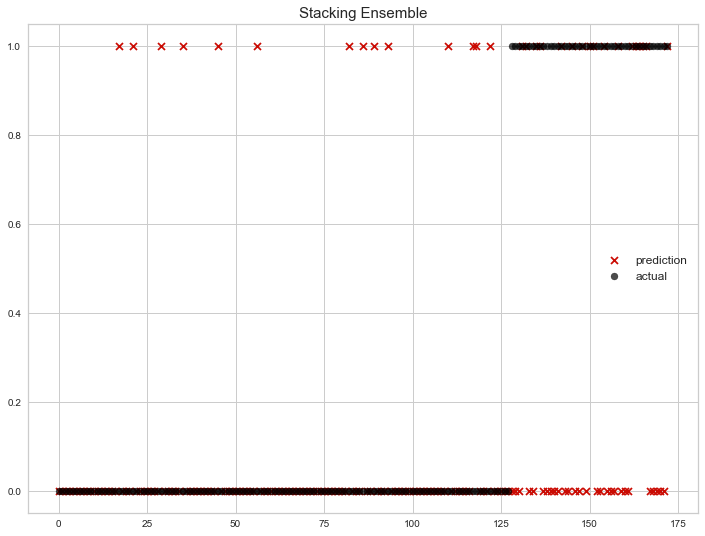

NameError: name 'my_predictions' is not defined

In [169]:
acc_eval('Stacking Ensemble', y_test, stack_pred)

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_predictions(name_, actual, pred):
    df = pd.DataFrame({'actual': y_test, 'prediction': pred})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [165]:
def acc_eval(name_, actual, pred):
    global predictions
    global colors

    plot_predictions(name_, actual, pred)

    mse = accuracy_score(actual, pred)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'acc'])
    print(df)
    min_ = df['acc'].min() - 10
    max_ = df['acc'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['acc'])
    
    for i, v in enumerate(df['acc']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('ACC Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()
